# Explore

In [64]:
import re
import unicodedata
from wordcloud import WordCloud
import pandas as pd
import nltk
import env

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

**get data**

In [24]:
url = env.get_db_access("spam_db")
sql = "SELECT * FROM spam"

df = pd.read_sql(sql, url, index_col="id")
df.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [25]:
def prep_data(text:str, more_stopwords):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer() # lemmitizer object
    # add more stop words to the original dictionary stop words from the english language
    stopwords = nltk.corpus.stopwords.words('english') + more_stopwords
    # normalize the string
    text = (unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore').lower())
    # remove not letters of numbers
    words = re.sub(r'[^\w\s]', '', text).split()
    # lemmatize the string
    lemma =  [wnl.lemmatize(word) for word in words if word not in stopwords]
    return lemma


**count of categories**

In [26]:
df.groupby("label").count()

,text
label,
ham,4825
spam,747


In [27]:
df.groupby("label").count().text/len(df)

label
ham     0.865937
spam    0.134063
Name: text, dtype: float64

**Nreak the data up into 3 seperate pieces**

- The words that appear in legitimate text messages.
- The words that appear in spam text messages.
- All of the words.

In [28]:
more_stopwords = ['r', 'u', '2', 'ltgt']
# select each gategory and join all series text together and them apply the cleaning function
ham_words = prep_data(' '.join(df[df.label == 'ham'].text), more_stopwords)
spam_words = prep_data(' '.join(df[df.label == 'spam'].text), more_stopwords)
all_words = prep_data(' '.join(df.text), more_stopwords)
all_words[:5]

['go', 'jurong', 'point', 'crazy', 'available']

**How many times does each word occur?**

In [32]:
# apply a value count to each category (count occurences of each unique word in the list)
ham_words_freq = pd.Series(ham_words).value_counts()
spam_words_freq = pd.Series(spam_words).value_counts()
all_words_freq = pd.Series(all_words).value_counts()

spam_words_freq.head()

call    359
free    216
txt     150
ur      144
text    137
dtype: int64

**Create a dataframe of the results**

In [33]:
freq_df = pd.concat([ham_words_freq, spam_words_freq, all_words_freq], axis=1).set_axis(["ham", "spam", "all"], axis=1)
freq_df

,ham,spam,all
im,449.0,13.0,462
get,314.0,83.0,397
go,273.0,31.0,304
ok,272.0,5.0,277
dont,257.0,22.0,279
...,...,...,...
resub,NaN,1.0,1
expired,NaN,1.0,1
9153,NaN,1.0,1
okmail,NaN,1.0,1


**What are the most frequently occuring words?**

In [34]:
# most occuring words over all categories
freq_df.sort_values(by='all', ascending=False).head(10)

,ham,spam,all
call,241.0,359.0,600
im,449.0,13.0,462
get,314.0,83.0,397
ur,240.0,144.0,384
go,273.0,31.0,304
4,168.0,119.0,287
dont,257.0,22.0,279
ok,272.0,5.0,277
free,59.0,216.0,275
know,241.0,26.0,267


In [35]:
# most occuring words based on ham
freq_df.sort_values(by='ham', ascending=False).head(10)

,ham,spam,all
im,449.0,13.0,462
get,314.0,83.0,397
go,273.0,31.0,304
ok,272.0,5.0,277
dont,257.0,22.0,279
come,242.0,5.0,247
know,241.0,26.0,267
call,241.0,359.0,600
ur,240.0,144.0,384
ill,236.0,1.0,237


In [36]:
# most occuring words based on span
freq_df.sort_values(by='spam', ascending=False).head(10)

,ham,spam,all
call,241.0,359.0,600
free,59.0,216.0,275
txt,13.0,150.0,163
ur,240.0,144.0,384
text,77.0,137.0,214
mobile,15.0,135.0,150
4,168.0,119.0,287
claim,NaN,115.0,115
stop,40.0,113.0,153
reply,43.0,102.0,145


**Are there any words that uniquely identify a spam or ham message?**

In [39]:
# fill nulls with 0
freq_df = freq_df.fillna(0)

# all the words beloge to the ham group
completly_ham = freq_df[["all", "spam"]][freq_df.spam == 0]
completly_ham.head()

,all,spam
lor,160,0.0
later,134,0.0
da,132,0.0
say,118,0.0
i_,117,0.0


In [40]:
# all the words beloge to the spam group
completly_spam =freq_df[["all", "ham"]][freq_df.ham == 0]
completly_spam.head()

,all,ham
claim,115,0.0
prize,94,0.0
tone,73,0.0
guaranteed,50,0.0
18,43,0.0


### Visualize

<function matplotlib.pyplot.show(close=None, block=None)>

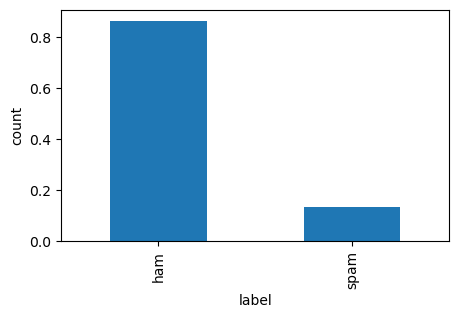

In [52]:
plt.figure(figsize=(5,3))
(df.groupby("label").count().text/len(df)).plot.bar()
plt.ylabel("count")
plt.show

In [53]:
# Assign new columns to a DataFrame.
freq_df = freq_df.assign(p_spam = freq_df.spam / freq_df["all"],
                         p_ham = freq_df.ham / freq_df["all"]).sort_values(by="all")
freq_df.tail()

,ham,spam,all,p_spam,p_ham
go,273.0,31.0,304,0.101974,0.898026
ur,240.0,144.0,384,0.375000,0.625000
get,314.0,83.0,397,0.209068,0.790932
im,449.0,13.0,462,0.028139,0.971861
call,241.0,359.0,600,0.598333,0.401667


<Figure size 800x400 with 0 Axes>

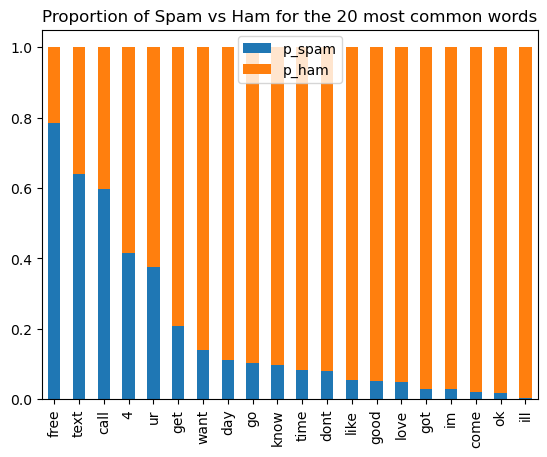

In [63]:
# figure out the percentage of spam vs ham
plt.figure(figsize=(8,4))
freq_df[['p_spam', 'p_ham']].tail(20).sort_values('p_ham').plot(kind="bar", stacked=True)
plt.title('Proportion of Spam vs Ham for the 20 most common words')
plt.show()

### Word Clound

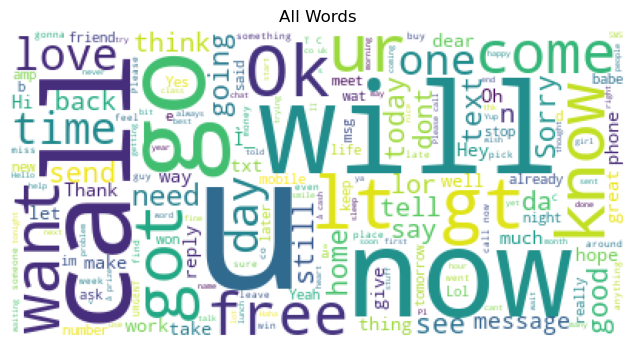

In [90]:
plt.figure(figsize=(8, 4))
all_cloud = WordCloud(background_color='white').generate(' '.join(df["text"]))
plt.title('All Words')
plt.axis('off') # turn off the y and x axis
plt.imshow(all_cloud) #show the word cloud

### Bigrams

**Find out which bigrams are the most frequently occuring.**

Text(0, 0.5, '# Occurances')

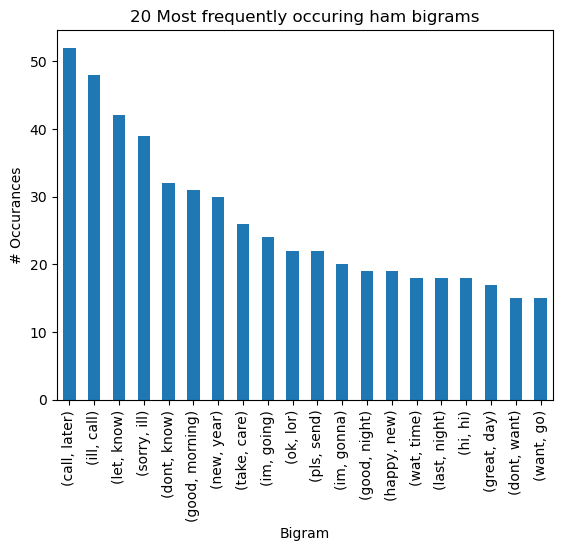

In [104]:
top_20_ham_bigrams = pd.Series(nltk.ngrams(ham_words, 2))

top_20_ham_bigrams.value_counts().head(20).plot(kind="bar")
plt.title('20 Most frequently occuring ham bigrams')
plt.xlabel('Bigram')
plt.ylabel('# Occurances')